<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt



In [75]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [77]:


def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [78]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [79]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        c =128
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=100)
        self.bn1 = nn.BatchNorm2d(c)
        self.bn2 = nn.BatchNorm2d(c*2)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [80]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        y = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(y) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits,x

In [81]:

# Sigmoid loss with logits, keep as tensor 
# z = labels , torch.ones_like discriminator sigmoid prob
# x =  discriminator logits prob 

def Sigmoid_logits_loss( logits,labels):
  z = labels
  x = logits 
  #z = z * -torch.log(torch.sigmoid(x)) + (1 - z) * -torch.log(1 - torch.sigmoid(x))
  #z = z * -torch.log(1 / (1 + torch.exp(-x))) + (1 - z) * -torch.log(torch.exp(-x) / (1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (-torch.log(torch.exp(-x)) + torch.log(1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (x + torch.log(1 + torch.exp(-x)))
  loss = 0
  for i, x in enumerate(x):
    for j, z in enumerate(z):
      if x >0:
        loss = x - x * z + torch.log(1 + torch.exp(-x))
      else:
        loss = - x * z + torch.log(1 + torch.exp(x))
      loss += loss
    return loss


# Creating GAN Network

In [94]:

from torch.autograd import grad as torch_grad
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        print(data.shape[1])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder().cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
      
    
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
                #x_ = x_.view(x_.size(0), -1)
               # z_ = z_.view(z_.size(0), -1)
                x_, z_ = x_.cuda() ,z_.cuda()
        
        

                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularization

            
          

                self.A_optimizer.zero_grad()
                # reconstructed image
                recon = self.A(x_)
                self.D_optimizer.zero_grad()
                self.G_optimizer.zero_grad()
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f
                
                
                D_real_prob, D_real_logits, D_real = self.D(x_)
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r)
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f)

                #print(D_real.shape)
                #print(x_.shape)

                ##auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                g = torch.mean(recon - z_) * 1.45  # distance between reconstruced imgs and noise # higher value = initial lowvD training loss  
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                # Train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                R_loss.backward()
                self.A_optimizer.step()

                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())


                #Train Generator with G_Loss 
               
                G_loss = torch.abs(torch.mean(D_real_prob)- torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######
                
                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
                


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits, d_inter = self.D(interpolation)

                # Gradien Penalty 
                gradients = torch_grad(d_inter_logits, interpolation, grad_outputs=torch.ones(d_inter_logits.size()).cuda())[0]
              
                slopes = torch.sqrt(torch.mean(torch.square(gradients),1))
                gp = torch.mean((slopes-1)**2)
            
                #print(D_real_logits.shape)
            
                # Discriminator loss on data
                d_loss_real = torch.mean(Sigmoid_logits_loss( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(Sigmoid_logits_loss(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(Sigmoid_logits_loss(D_fake_logits,torch.zeros_like(D_fake_prob)))
               # print(d_loss_real.shape)

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

          
              
                #train Discriminator 
                D_loss.backward()
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
             
                #self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
    
                      # Visualize results
            with torch.no_grad():
              visualize_results(self)
            if epoch== 10:  
           

              print('Generator Reconstruction Images at 10 Epoch')
              visualise_output(self)
            
            if epoch   == 20:  
          

              print('Generator Reconstruction Images at 20 Epoch')
              visualise_output(self)
            if epoch  == 30:  
           

              print('Generator Reconstruction Images at 30 Epoch')
              visualise_output(self)
            if epoch  == 40:  
            

              print('Generator Reconstruction Images at 40 Epoch')
              visualise_output(self)

        print("Training finished!")

In [83]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  with torch.no_grad():
    z = torch.rand((gan.base_size, gan.z_dim)).cuda()
    z = gan.G(z)
    z = z.cpu()
    unique, counts = np.unique(z, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.xlabel("Label")
    plt.ylabel("Quantity")
    plt.title("Labels in MNIST 784 dataset")

1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 5.22066641, G_loss: 0.00131482
Epoch: [ 1] [ 100/ 200] D_loss: 6.76770496, G_loss: 0.00535512
Epoch: [ 1] [ 150/ 200] D_loss: 5.60394859, G_loss: 0.00324357
Epoch: [ 1] [ 200/ 200] D_loss: 2.85137272, G_loss: 0.00554287


<Figure size 72x720 with 0 Axes>

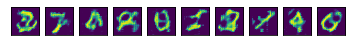

Epoch: [ 2] [  50/ 200] D_loss: 3.42759967, G_loss: 0.01185292
Epoch: [ 2] [ 100/ 200] D_loss: 5.73883295, G_loss: 0.00059479
Epoch: [ 2] [ 150/ 200] D_loss: 4.94711256, G_loss: 0.00275415
Epoch: [ 2] [ 200/ 200] D_loss: 6.31315899, G_loss: 0.00040853


<Figure size 72x720 with 0 Axes>

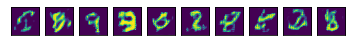

Epoch: [ 3] [  50/ 200] D_loss: 6.89533377, G_loss: 0.00647628
Epoch: [ 3] [ 100/ 200] D_loss: 7.70777130, G_loss: 0.00231260
Epoch: [ 3] [ 150/ 200] D_loss: 7.74485016, G_loss: 0.00516218
Epoch: [ 3] [ 200/ 200] D_loss: 4.64580917, G_loss: 0.00461030


<Figure size 72x720 with 0 Axes>

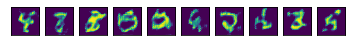

Epoch: [ 4] [  50/ 200] D_loss: 2.87611699, G_loss: 0.00131845
Epoch: [ 4] [ 100/ 200] D_loss: 3.96625686, G_loss: 0.00087970
Epoch: [ 4] [ 150/ 200] D_loss: 3.20424938, G_loss: 0.00918025
Epoch: [ 4] [ 200/ 200] D_loss: 5.30046892, G_loss: 0.00269741


<Figure size 72x720 with 0 Axes>

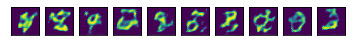

Epoch: [ 5] [  50/ 200] D_loss: 7.01881838, G_loss: 0.00072348
Epoch: [ 5] [ 100/ 200] D_loss: 4.73341417, G_loss: 0.00165266
Epoch: [ 5] [ 150/ 200] D_loss: 6.09816122, G_loss: 0.00392246
Epoch: [ 5] [ 200/ 200] D_loss: 16.26007462, G_loss: 0.00266850


<Figure size 72x720 with 0 Axes>

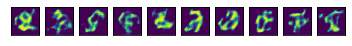

Epoch: [ 6] [  50/ 200] D_loss: 5.08596420, G_loss: 0.00658840
Epoch: [ 6] [ 100/ 200] D_loss: 5.96149778, G_loss: 0.00826401
Epoch: [ 6] [ 150/ 200] D_loss: 2.64398837, G_loss: 0.01509470
Epoch: [ 6] [ 200/ 200] D_loss: 6.61267853, G_loss: 0.00748235


<Figure size 72x720 with 0 Axes>

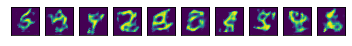

Epoch: [ 7] [  50/ 200] D_loss: 5.39707947, G_loss: 0.00263941
Epoch: [ 7] [ 100/ 200] D_loss: 4.86603546, G_loss: 0.00221944
Epoch: [ 7] [ 150/ 200] D_loss: 3.06359053, G_loss: 0.00321734
Epoch: [ 7] [ 200/ 200] D_loss: 10.13041687, G_loss: 0.00129801


<Figure size 72x720 with 0 Axes>

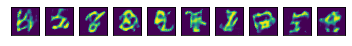

Epoch: [ 8] [  50/ 200] D_loss: 7.14141273, G_loss: 0.00033742
Epoch: [ 8] [ 100/ 200] D_loss: 3.89863729, G_loss: 0.00258803
Epoch: [ 8] [ 150/ 200] D_loss: 5.44631481, G_loss: 0.00012583
Epoch: [ 8] [ 200/ 200] D_loss: 3.68717408, G_loss: 0.00038344


<Figure size 72x720 with 0 Axes>

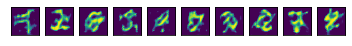

Epoch: [ 9] [  50/ 200] D_loss: 4.38952923, G_loss: 0.00110209
Epoch: [ 9] [ 100/ 200] D_loss: 4.56396055, G_loss: 0.00302082
Epoch: [ 9] [ 150/ 200] D_loss: 5.30053425, G_loss: 0.00215679
Epoch: [ 9] [ 200/ 200] D_loss: 5.10912657, G_loss: 0.00315076


<Figure size 72x720 with 0 Axes>

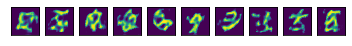

Epoch: [10] [  50/ 200] D_loss: 6.17788458, G_loss: 0.00339955
Epoch: [10] [ 100/ 200] D_loss: 4.63463306, G_loss: 0.00680512
Epoch: [10] [ 150/ 200] D_loss: 5.17678356, G_loss: 0.00437891
Epoch: [10] [ 200/ 200] D_loss: 8.91396618, G_loss: 0.00348788


<Figure size 72x720 with 0 Axes>

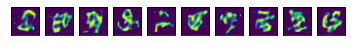

Epoch: [11] [  50/ 200] D_loss: 10.72388363, G_loss: 0.00912428
Epoch: [11] [ 100/ 200] D_loss: 4.25452471, G_loss: 0.01157022
Epoch: [11] [ 150/ 200] D_loss: 5.14816999, G_loss: 0.01244450
Epoch: [11] [ 200/ 200] D_loss: 8.01468372, G_loss: 0.02216512


<Figure size 72x720 with 0 Axes>

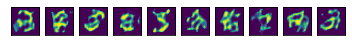

Generator Reconstruction Images at 10 Epoch


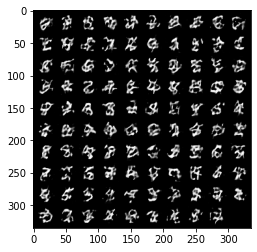

Epoch: [12] [  50/ 200] D_loss: 5.49047565, G_loss: 0.02460033
Epoch: [12] [ 100/ 200] D_loss: 4.34803009, G_loss: 0.01634127
Epoch: [12] [ 150/ 200] D_loss: 6.20106030, G_loss: 0.01125222
Epoch: [12] [ 200/ 200] D_loss: 7.75449800, G_loss: 0.01690692


<Figure size 72x720 with 0 Axes>

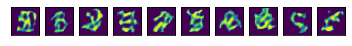

Epoch: [13] [  50/ 200] D_loss: 4.06938553, G_loss: 0.01466656
Epoch: [13] [ 100/ 200] D_loss: 4.13577938, G_loss: 0.02095121
Epoch: [13] [ 150/ 200] D_loss: 8.52453232, G_loss: 0.03371656
Epoch: [13] [ 200/ 200] D_loss: 4.64182663, G_loss: 0.03350323


<Figure size 72x720 with 0 Axes>

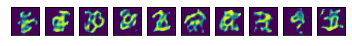

Epoch: [14] [  50/ 200] D_loss: 3.78583837, G_loss: 0.02451026
Epoch: [14] [ 100/ 200] D_loss: 5.56175327, G_loss: 0.03366441
Epoch: [14] [ 150/ 200] D_loss: 5.21034050, G_loss: 0.02784806
Epoch: [14] [ 200/ 200] D_loss: 4.16758251, G_loss: 0.03214478


<Figure size 72x720 with 0 Axes>

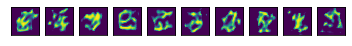

Epoch: [15] [  50/ 200] D_loss: 7.19389296, G_loss: 0.03812879
Epoch: [15] [ 100/ 200] D_loss: 5.72117805, G_loss: 0.03433806
Epoch: [15] [ 150/ 200] D_loss: 2.69874883, G_loss: 0.05118573
Epoch: [15] [ 200/ 200] D_loss: 3.21052527, G_loss: 0.05134660


<Figure size 72x720 with 0 Axes>

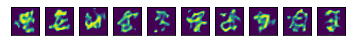

Epoch: [16] [  50/ 200] D_loss: 6.82187986, G_loss: 0.05043429
Epoch: [16] [ 100/ 200] D_loss: 5.15997124, G_loss: 0.05264866
Epoch: [16] [ 150/ 200] D_loss: 4.07915306, G_loss: 0.05470961
Epoch: [16] [ 200/ 200] D_loss: 4.41111374, G_loss: 0.03165835


<Figure size 72x720 with 0 Axes>

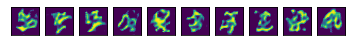

Epoch: [17] [  50/ 200] D_loss: 8.23288441, G_loss: 0.05552846
Epoch: [17] [ 100/ 200] D_loss: 4.47520542, G_loss: 0.05858099
Epoch: [17] [ 150/ 200] D_loss: 5.58628654, G_loss: 0.06153065
Epoch: [17] [ 200/ 200] D_loss: 4.27133560, G_loss: 0.05395049


<Figure size 72x720 with 0 Axes>

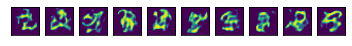

Epoch: [18] [  50/ 200] D_loss: 5.15389347, G_loss: 0.06926000
Epoch: [18] [ 100/ 200] D_loss: 4.45192528, G_loss: 0.06270057
Epoch: [18] [ 150/ 200] D_loss: 4.88052416, G_loss: 0.06031001
Epoch: [18] [ 200/ 200] D_loss: 10.50928783, G_loss: 0.06813675


<Figure size 72x720 with 0 Axes>

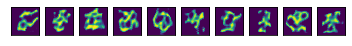

Epoch: [19] [  50/ 200] D_loss: 5.46163559, G_loss: 0.06914467
Epoch: [19] [ 100/ 200] D_loss: 3.34869051, G_loss: 0.06583875
Epoch: [19] [ 150/ 200] D_loss: 4.32837200, G_loss: 0.06800044
Epoch: [19] [ 200/ 200] D_loss: 3.60100913, G_loss: 0.07775486


<Figure size 72x720 with 0 Axes>

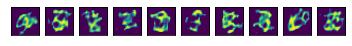

Epoch: [20] [  50/ 200] D_loss: 3.82993460, G_loss: 0.08452249
Epoch: [20] [ 100/ 200] D_loss: 6.73142529, G_loss: 0.10220051
Epoch: [20] [ 150/ 200] D_loss: 4.50004959, G_loss: 0.08664602
Epoch: [20] [ 200/ 200] D_loss: 5.68759537, G_loss: 0.11556655


<Figure size 72x720 with 0 Axes>

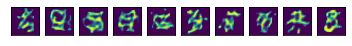

Epoch: [21] [  50/ 200] D_loss: 5.31580448, G_loss: 0.12169582
Epoch: [21] [ 100/ 200] D_loss: 4.55729008, G_loss: 0.09470439
Epoch: [21] [ 150/ 200] D_loss: 4.45463610, G_loss: 0.11493927
Epoch: [21] [ 200/ 200] D_loss: 4.36917973, G_loss: 0.11230302


<Figure size 72x720 with 0 Axes>

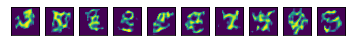

Generator Reconstruction Images at 20 Epoch


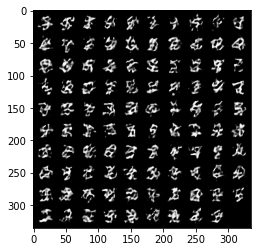

Epoch: [22] [  50/ 200] D_loss: 6.58213663, G_loss: 0.11520970
Epoch: [22] [ 100/ 200] D_loss: 4.96806669, G_loss: 0.10880280
Epoch: [22] [ 150/ 200] D_loss: 5.70341730, G_loss: 0.12809032
Epoch: [22] [ 200/ 200] D_loss: 5.60702229, G_loss: 0.11877519


<Figure size 72x720 with 0 Axes>

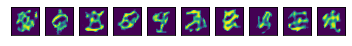

Epoch: [23] [  50/ 200] D_loss: 2.61173630, G_loss: 0.12454575
Epoch: [23] [ 100/ 200] D_loss: 2.93097138, G_loss: 0.12171108
Epoch: [23] [ 150/ 200] D_loss: 4.95158911, G_loss: 0.12524664
Epoch: [23] [ 200/ 200] D_loss: 2.79038095, G_loss: 0.11880189


<Figure size 72x720 with 0 Axes>

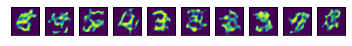

Epoch: [24] [  50/ 200] D_loss: 3.39072871, G_loss: 0.14057088
Epoch: [24] [ 100/ 200] D_loss: 4.58445740, G_loss: 0.15611660
Epoch: [24] [ 150/ 200] D_loss: 4.98618078, G_loss: 0.15356332
Epoch: [24] [ 200/ 200] D_loss: 5.86118793, G_loss: 0.17968178


<Figure size 72x720 with 0 Axes>

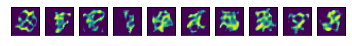

Epoch: [25] [  50/ 200] D_loss: 5.14494896, G_loss: 0.13789129
Epoch: [25] [ 100/ 200] D_loss: 4.64560747, G_loss: 0.15589237
Epoch: [25] [ 150/ 200] D_loss: 6.76003838, G_loss: 0.16324681
Epoch: [25] [ 200/ 200] D_loss: 6.10465193, G_loss: 0.19038141


<Figure size 72x720 with 0 Axes>

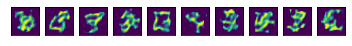

Epoch: [26] [  50/ 200] D_loss: 3.73843050, G_loss: 0.20060080
Epoch: [26] [ 100/ 200] D_loss: 5.29023266, G_loss: 0.21671867
Epoch: [26] [ 150/ 200] D_loss: 4.04343462, G_loss: 0.17948478
Epoch: [26] [ 200/ 200] D_loss: 4.36878300, G_loss: 0.19431543


<Figure size 72x720 with 0 Axes>

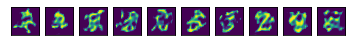

Epoch: [27] [  50/ 200] D_loss: 4.78599453, G_loss: 0.19790417
Epoch: [27] [ 100/ 200] D_loss: 7.05221367, G_loss: 0.18990618
Epoch: [27] [ 150/ 200] D_loss: 2.64251256, G_loss: 0.21654123
Epoch: [27] [ 200/ 200] D_loss: 3.85416913, G_loss: 0.19293493


<Figure size 72x720 with 0 Axes>

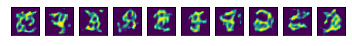

Epoch: [28] [  50/ 200] D_loss: 1.92303443, G_loss: 0.23340178
Epoch: [28] [ 100/ 200] D_loss: 7.25421906, G_loss: 0.25532746
Epoch: [28] [ 150/ 200] D_loss: 1.78398800, G_loss: 0.21942931
Epoch: [28] [ 200/ 200] D_loss: 4.34383059, G_loss: 0.20805326


<Figure size 72x720 with 0 Axes>

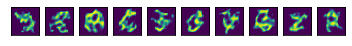

Epoch: [29] [  50/ 200] D_loss: 3.84420514, G_loss: 0.23199683
Epoch: [29] [ 100/ 200] D_loss: 5.60666180, G_loss: 0.23439881
Epoch: [29] [ 150/ 200] D_loss: 2.72441888, G_loss: 0.27819932
Epoch: [29] [ 200/ 200] D_loss: 1.42369223, G_loss: 0.25428072


<Figure size 72x720 with 0 Axes>

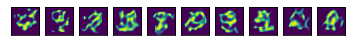

Epoch: [30] [  50/ 200] D_loss: 2.70025349, G_loss: 0.27028230
Epoch: [30] [ 100/ 200] D_loss: 3.74229240, G_loss: 0.27622858
Epoch: [30] [ 150/ 200] D_loss: 2.79864717, G_loss: 0.28295577
Epoch: [30] [ 200/ 200] D_loss: 4.35099697, G_loss: 0.27360839


<Figure size 72x720 with 0 Axes>

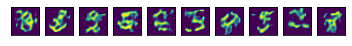

Epoch: [31] [  50/ 200] D_loss: 2.85183477, G_loss: 0.27250040
Epoch: [31] [ 100/ 200] D_loss: 3.72923875, G_loss: 0.24268657
Epoch: [31] [ 150/ 200] D_loss: 4.72740889, G_loss: 0.29839861
Epoch: [31] [ 200/ 200] D_loss: 4.51877451, G_loss: 0.28389010


<Figure size 72x720 with 0 Axes>

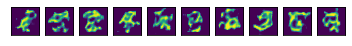

Generator Reconstruction Images at 30 Epoch


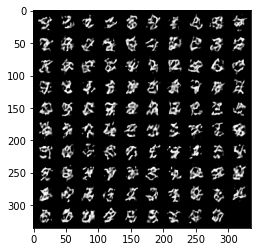

Epoch: [32] [  50/ 200] D_loss: 3.91364646, G_loss: 0.30247936
Epoch: [32] [ 100/ 200] D_loss: 1.47392845, G_loss: 0.29147649
Epoch: [32] [ 150/ 200] D_loss: 2.97432470, G_loss: 0.31348285
Epoch: [32] [ 200/ 200] D_loss: 5.39065123, G_loss: 0.33186227


<Figure size 72x720 with 0 Axes>

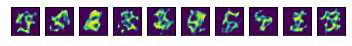

Epoch: [33] [  50/ 200] D_loss: 7.39256287, G_loss: 0.29454398
Epoch: [33] [ 100/ 200] D_loss: 3.51182270, G_loss: 0.30840006
Epoch: [33] [ 150/ 200] D_loss: 4.27277470, G_loss: 0.33485019
Epoch: [33] [ 200/ 200] D_loss: 2.93134785, G_loss: 0.32182756


<Figure size 72x720 with 0 Axes>

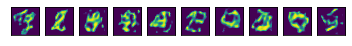

Epoch: [34] [  50/ 200] D_loss: 3.54217219, G_loss: 0.32930833
Epoch: [34] [ 100/ 200] D_loss: 1.92597604, G_loss: 0.32931793
Epoch: [34] [ 150/ 200] D_loss: 3.72735548, G_loss: 0.35195997
Epoch: [34] [ 200/ 200] D_loss: 2.72232842, G_loss: 0.37924328


<Figure size 72x720 with 0 Axes>

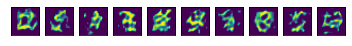

Epoch: [35] [  50/ 200] D_loss: 2.49808455, G_loss: 0.33298856
Epoch: [35] [ 100/ 200] D_loss: 6.03500366, G_loss: 0.36035171
Epoch: [35] [ 150/ 200] D_loss: 3.57865238, G_loss: 0.39228463
Epoch: [35] [ 200/ 200] D_loss: 4.92380238, G_loss: 0.36425275


<Figure size 72x720 with 0 Axes>

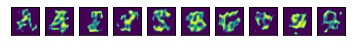

Epoch: [36] [  50/ 200] D_loss: 1.47458005, G_loss: 0.36758894
Epoch: [36] [ 100/ 200] D_loss: 1.75316906, G_loss: 0.38502407
Epoch: [36] [ 150/ 200] D_loss: 4.41230297, G_loss: 0.40614048
Epoch: [36] [ 200/ 200] D_loss: 1.46026969, G_loss: 0.38770643


<Figure size 72x720 with 0 Axes>

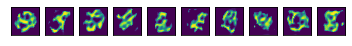

Epoch: [37] [  50/ 200] D_loss: 1.67780209, G_loss: 0.35758156
Epoch: [37] [ 100/ 200] D_loss: 2.88582206, G_loss: 0.44446355
Epoch: [37] [ 150/ 200] D_loss: 3.45892859, G_loss: 0.44169778
Epoch: [37] [ 200/ 200] D_loss: 1.37394738, G_loss: 0.41281304


<Figure size 72x720 with 0 Axes>

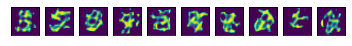

Epoch: [38] [  50/ 200] D_loss: 6.25214958, G_loss: 0.43508938
Epoch: [38] [ 100/ 200] D_loss: 1.33154655, G_loss: 0.46616104
Epoch: [38] [ 150/ 200] D_loss: 3.16288877, G_loss: 0.42132309
Epoch: [38] [ 200/ 200] D_loss: 4.48520136, G_loss: 0.44950339


<Figure size 72x720 with 0 Axes>

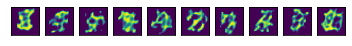

Epoch: [39] [  50/ 200] D_loss: 2.84317517, G_loss: 0.46363252
Epoch: [39] [ 100/ 200] D_loss: 4.01523733, G_loss: 0.49478471
Epoch: [39] [ 150/ 200] D_loss: 2.32725763, G_loss: 0.46350202
Epoch: [39] [ 200/ 200] D_loss: 2.46456671, G_loss: 0.49309584


<Figure size 72x720 with 0 Axes>

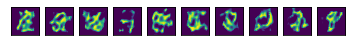

Epoch: [40] [  50/ 200] D_loss: 3.81175804, G_loss: 0.47534585
Epoch: [40] [ 100/ 200] D_loss: 1.64596224, G_loss: 0.47039893
Epoch: [40] [ 150/ 200] D_loss: 1.12410426, G_loss: 0.47753438
Epoch: [40] [ 200/ 200] D_loss: 6.00259876, G_loss: 0.45699671


<Figure size 72x720 with 0 Axes>

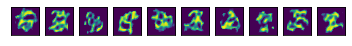

Epoch: [41] [  50/ 200] D_loss: 1.94088674, G_loss: 0.49203926
Epoch: [41] [ 100/ 200] D_loss: 4.65842819, G_loss: 0.45658907
Epoch: [41] [ 150/ 200] D_loss: 2.33244801, G_loss: 0.42843705
Epoch: [41] [ 200/ 200] D_loss: 2.24146843, G_loss: 0.47912461


<Figure size 72x720 with 0 Axes>

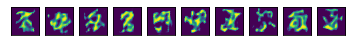

Generator Reconstruction Images at 40 Epoch


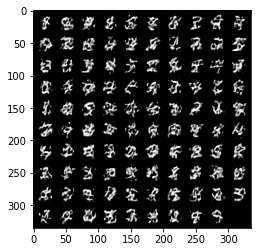

Epoch: [42] [  50/ 200] D_loss: 2.40466356, G_loss: 0.49458870
Epoch: [42] [ 100/ 200] D_loss: 1.35419393, G_loss: 0.50576746
Epoch: [42] [ 150/ 200] D_loss: 1.22431087, G_loss: 0.47130862
Epoch: [42] [ 200/ 200] D_loss: 4.11828852, G_loss: 0.49046281


<Figure size 72x720 with 0 Axes>

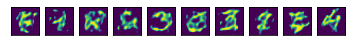

Epoch: [43] [  50/ 200] D_loss: 3.04200292, G_loss: 0.47663361
Epoch: [43] [ 100/ 200] D_loss: 1.32640851, G_loss: 0.51267695
Epoch: [43] [ 150/ 200] D_loss: 2.40984869, G_loss: 0.51149076
Epoch: [43] [ 200/ 200] D_loss: 5.77283478, G_loss: 0.52165711


<Figure size 72x720 with 0 Axes>

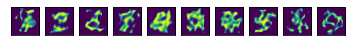

Epoch: [44] [  50/ 200] D_loss: 1.22984195, G_loss: 0.54745829
Epoch: [44] [ 100/ 200] D_loss: 1.28473175, G_loss: 0.52055395
Epoch: [44] [ 150/ 200] D_loss: 2.52085757, G_loss: 0.52937192
Epoch: [44] [ 200/ 200] D_loss: 1.88296950, G_loss: 0.52068722


<Figure size 72x720 with 0 Axes>

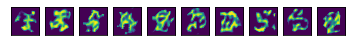

Epoch: [45] [  50/ 200] D_loss: 3.57757115, G_loss: 0.53601861
Epoch: [45] [ 100/ 200] D_loss: 1.83275104, G_loss: 0.54957604
Epoch: [45] [ 150/ 200] D_loss: 3.61585426, G_loss: 0.53647321
Epoch: [45] [ 200/ 200] D_loss: 6.63482904, G_loss: 0.52483344


<Figure size 72x720 with 0 Axes>

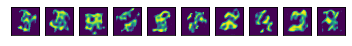

Epoch: [46] [  50/ 200] D_loss: 3.81308746, G_loss: 0.54590368
Epoch: [46] [ 100/ 200] D_loss: 4.88737869, G_loss: 0.57224864
Epoch: [46] [ 150/ 200] D_loss: 1.91091394, G_loss: 0.58723736
Epoch: [46] [ 200/ 200] D_loss: 3.27613473, G_loss: 0.59835917


<Figure size 72x720 with 0 Axes>

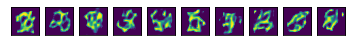

Epoch: [47] [  50/ 200] D_loss: 1.83492935, G_loss: 0.51680934
Epoch: [47] [ 100/ 200] D_loss: 1.15643549, G_loss: 0.53501326
Epoch: [47] [ 150/ 200] D_loss: 3.82310677, G_loss: 0.52057862
Epoch: [47] [ 200/ 200] D_loss: 1.06834972, G_loss: 0.55850518


<Figure size 72x720 with 0 Axes>

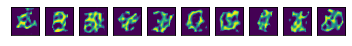

Epoch: [48] [  50/ 200] D_loss: 3.13563204, G_loss: 0.58666527
Epoch: [48] [ 100/ 200] D_loss: 2.44249558, G_loss: 0.56282389
Epoch: [48] [ 150/ 200] D_loss: 1.30324137, G_loss: 0.55792147
Epoch: [48] [ 200/ 200] D_loss: 1.11208308, G_loss: 0.61028969


<Figure size 72x720 with 0 Axes>

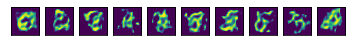

Epoch: [49] [  50/ 200] D_loss: 4.30489349, G_loss: 0.61768180
Epoch: [49] [ 100/ 200] D_loss: 4.44441652, G_loss: 0.60448825
Epoch: [49] [ 150/ 200] D_loss: 1.22184157, G_loss: 0.61553252
Epoch: [49] [ 200/ 200] D_loss: 1.94667983, G_loss: 0.59764862


<Figure size 72x720 with 0 Axes>

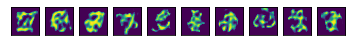

Epoch: [50] [  50/ 200] D_loss: 1.13740277, G_loss: 0.53023517
Epoch: [50] [ 100/ 200] D_loss: 1.76005888, G_loss: 0.56711447
Epoch: [50] [ 150/ 200] D_loss: 5.33077908, G_loss: 0.60847998
Epoch: [50] [ 200/ 200] D_loss: 1.10429740, G_loss: 0.58053678


<Figure size 72x720 with 0 Axes>

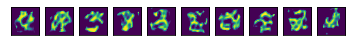

Epoch: [51] [  50/ 200] D_loss: 1.94171011, G_loss: 0.61823416
Epoch: [51] [ 100/ 200] D_loss: 2.15405703, G_loss: 0.63107532


In [ ]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':100}

params['z_dim'] = 100
params['base_size'] = 128

gan = GAN(params)


gan.train()